In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import yaml
import json
from itertools import product

import intake

import pandas as pd
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt

import pop_tools
import operators as ops
import util

In [3]:
with open("timeseries-vars.yml") as fid:
    variables_info = yaml.load(fid, Loader=yaml.Loader)
variables_info = {
    d["varname"]: {k: v for k, v in d.items() if k != "varname"} for d in variables_info
}
variables_info

{'POC_FLUX_100m': {'spatial_op': 'integrate',
  'integral_unit_conv': '(12 g)/(mol)',
  'integral_display_units': 'Pg / yr',
  'display_units': 'mol / m^2 / yr',
  'map_vmin': 0.01,
  'map_vmax': 10.0,
  'apply_log10': True},
 'CaCO3_FLUX_100m': {'spatial_op': 'integrate',
  'integral_unit_conv': '(12 g)/(mol)',
  'integral_display_units': 'Pg / yr',
  'display_units': 'mol / m^2 / yr',
  'map_vmin': 0.001,
  'map_vmax': 3.0,
  'apply_log10': True},
 'FG_CO2': {'spatial_op': 'integrate',
  'integral_unit_conv': '(12 g)/(mol)',
  'integral_display_units': 'Pg / yr',
  'display_units': 'mol / m^2 / yr',
  'map_vmin': -10.0,
  'map_vmax': 10.0},
 'DpCO2': {'spatial_op': 'average', 'map_vmin': -75.0, 'map_vmax': 75.0},
 'PH': {'spatial_op': 'average', 'map_vmin': 8.0, 'map_vmax': 8.4}}

In [4]:
clobber = True
catalog_file = 'data/campaign-cesm2-cmip6-timeseries.json'
query = dict(
    experiment='historical',
)

variable_list = ['POC_FLUX_100m']

In [5]:
with open(catalog_file) as fid:
    catalog_id = json.load(fid)['id']
catalog_id

'campaign-cesm2-cmip6-timeseries'

In [6]:
catalog = intake.open_esm_datastore(catalog_file)
catalog_key_info = util.intake_esm_get_keys_info(catalog)
catalog

,unique
Unnamed: 0,312503
experiment,13
case,33
component,6
stream,22
variable,2641
date_range,596
member_id,12
path,312503
ctrl_branch_year,18


In [7]:
cluster, client = util.get_ClusterClient()
cluster.scale(24) #adapt(minimum_jobs=0, maximum_jobs=24)
client

/glade/work/mclong/miniconda3/envs/cesm2-marbl/lib/python3.7/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: tcp://10.12.206.51:34981 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/proxy/45385/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


/glade/work/mclong/miniconda3/envs/cesm2-marbl/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.
  warnings.warn(problem)


<xarray.DataArray 'region' (region: 4)>
array(['Global', 'Atlantic Ocean', 'Pacific Ocean', 'Indian Ocean'],
      dtype='<U14')
Coordinates:
  * region   (region) <U14 'Global' 'Atlantic Ocean' ... 'Indian Ocean'

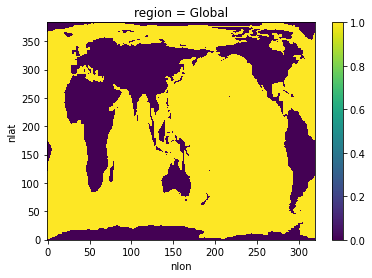

In [8]:
mask3d = pop_tools.region_mask_3d('POP_gx1v7', mask_name='Pacific-Indian-Atlantic')
mask3d.isel(region=0).plot();
mask3d.region

In [17]:
for variable in variable_list:
    catalog_subset = catalog.search(variable=variable, **query)
    member_ids = list(catalog_subset.df.member_id.unique())

    assert variables_info[variable]["spatial_op"] in ["average", "integrate"]
    normalize = variables_info[variable]["spatial_op"] == "average"

    for member_id in member_ids:
        dsets = catalog_subset.search(member_id=member_id).to_dataset_dict()

        for key, ds in dsets.items():
            asset = f"assets/{catalog_id}.{key}.{variable}.{member_id:03d}.zarr"
            asset_meta = f"assets/{catalog_id}.{key}.{variable}.{member_id:03d}.yml"
            metadata = dict(
                catalog_file=catalog_file,
                key=key,                   
                variable=variable,
                member_id=int(member_id),
                name='ann-timeseries',
                asset=asset,
            )         
            
            if os.path.exists(asset) and not clobber:
                continue

            ds_list = []
            for i in range(mask3d.sizes["region"]):
                dsi = (
                    ops.resample_ann(ds)[[variable, "TAREA", "KMT", "REGION_MASK"]]
                    .where(mask3d.isel(region=i) == 1.0)
                    .isel(member_id=0, drop=True)
                )
                dsi["time_bound"] = ds.time_bound
                ds_list.append(
                    ops.global_mean(dsi, normalize=normalize)[[variable]]
                )
            dso = xr.concat(ds_list, dim=mask3d.region)            
            dso.to_zarr(asset, mode='w', consolidated=True)
            with open(asset_meta, 'w') as fid:
                yaml.dump(metadata, fid)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'


In [ ]:
del client
del cluster